# A demo of using RDKitFF and OpenBabelFF
Demonstrate using the force field wrapper `RDKitFF` for RDKit force field and `OpenBabelFF` for Openbabel force field. Compared to the original APIs,
- ROO cannot be optimized by RDKit Force Field, but RDKitFF provides a workaround for it.
- more consistent APIs using RDKitFF and OpenBabelFF

Something needs to keep in mind:
- OpenBabelFF by default allowing interfragmental interactions, but you need to set `ignore_interfrag_interactions=False` to allow interfragmental interactions for RDKitFF.
- When dealing with constrained optimization, in using OpenBabelFF, you need to set constraint before calling `setup()` (or calling `setup()` again after setting constraints); but in RDKitFF, you can only set constraint after calling `setup()`

In [10]:
from pathlib import Path
import sys
# To add this RDMC into PYTHONPATH in case you doesn't do it
sys.path.append(str(Path("").absolute().parent))

import numpy as np
import matplotlib.pyplot as plt

from rdmc import OpenBabelFF, RDKitFF, Mol
from rdmc.plotter import plot_curve
from rdtools.view import grid_viewer, mol_viewer, animation_viewer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. RDKit Force Field

In [4]:
mol1 = Mol.FromSmiles('CCCO[O]')
mol1.EmbedConformer()

Create a force field object. Other options are `mmff94` and `uff`

In [5]:
ff = RDKitFF('mmff94s')
print(ff.type)

mmff94s


Check optimizibility and make molecule optimizable

In [6]:
opt_mol = mol1.Copy()
ff.setup(opt_mol, ignore_interfrag_interactions=False)
print(f'Optimizability of this molecule: {ff.is_optimizable()}')

Optimizability of this molecule: True


Optimize a single conformer (conformer 0)

In [8]:
success = ff.optimize()
print(f'Optimization success: {success}')
opt_mol = ff.get_optimized_mol()
mol_viewer(opt_mol)

Optimization success: True


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 2. Openbabel Force Field

Create a Openbabel force field object. Options are `mmff94`, `mmff94s`, `uff`, `gaff`

In [10]:
obff = OpenBabelFF('gaff')
print(obff.type)

gaff


Check optimizibility and make molecule optimizable

In [11]:
opt_mol = mol1.Copy()
obff.setup(opt_mol)
print(f'Optimizability of this molecule: {obff.is_optimizable()}')

Optimizability of this molecule: True


In [13]:
obff.optimize()
opt_mol = obff.get_optimized_mol()
mol_viewer(opt_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 3. Intermolecular optimization
RDKitFF and OpenBabelFF may not converge to the same orientation due to being differently parametrized

Before Optimization

In [16]:
mol2 = Mol.FromSmiles('C=O.C=O')
mol2.EmbedConformer()
mol_viewer(mol2)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RDKitFF

In [18]:
ff = RDKitFF()
ff.setup(mol2.Copy(), ignore_interfrag_interactions=False)
ff.optimize()
mol_viewer(ff.get_optimized_mol())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

OpenBabelFF

In [19]:
ff = OpenBabelFF()
ff.setup(mol2.Copy())
ff.optimize()
mol_viewer(ff.get_optimized_mol())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 4. Constrained optimization

Set atom (1, 2) and (0, 3) = 2 Angstrom

In [24]:
xyz = """C      2.164196    0.180658    0.005381
O      0.942631    0.078687    0.002344
C     -2.138178   -0.178485   -0.005316
O     -3.360016   -0.280479   -0.008354
H      2.826486   -0.691971    0.123773
H      2.673219    1.151062   -0.110098
H     -1.518697   -0.529599   -0.845624
H     -1.589641    0.270129    0.837895"""

mol3 = Mol.FromXYZ(xyz, header=False)

print('Before optimization')
print(
      f'd(1,2) = {mol3.GetEditableConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {mol3.GetEditableConformer().GetBondLength([0,3])}\n'
)
mol_viewer(mol3)

Before optimization
d(1,2) = 3.091533633597571
d(0,3) = 5.54344245067431



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Constrained optimization with RDKitFF

In [23]:
ff = RDKitFF()
ff.setup(mol3.Copy())
ff.add_distance_constraint([1,2], 2.0, force_constant=1e4)
ff.add_distance_constraint([0,3], 2.0, force_constant=1e4)
ff.optimize()
opt_mol = ff.get_optimized_mol()
print("After Optimization:")
print(
    f'd(1,2) = {opt_mol.GetEditableConformer().GetBondLength([1,2])}\n'
    f'd(0,3) = {opt_mol.GetEditableConformer().GetBondLength([0,3])}\n'
)
mol_viewer(opt_mol)

After Optimization:
d(1,2) = 2.0104161144672386
d(0,3) = 2.0104161207438698



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Constrained optimization with OpenBabelFF

In [26]:
ff = OpenBabelFF()
ff.setup(mol3.Copy())  # directly assign mol to allow correct atom index when setting constraints
ff.add_distance_constraint([1,2], 2.0)
ff.add_distance_constraint([0,3], 2.0)
ff.optimize()
opt_mol = ff.get_optimized_mol()

print(
    f'd(1,2) = {opt_mol.GetEditableConformer().GetBondLength([1,2])}\n'
    f'd(0,3) = {opt_mol.GetEditableConformer().GetBondLength([0,3])}\n'
)
mol_viewer(opt_mol)

d(1,2) = 2.0010775081854573
d(0,3) = 2.000991178438568



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 5. Simultaneous constrained optimization for multiple conformers

In [29]:
xyz = """C      2.164196    0.180658    0.005381
O      0.942631    0.078687    0.002344
C     -2.138178   -0.178485   -0.005316
O     -3.360016   -0.280479   -0.008354
H      2.826486   -0.691971    0.123773
H      2.673219    1.151062   -0.110098
H     -1.518697   -0.529599   -0.845624
H     -1.589641    0.270129    0.837895"""

mol5 = Mol.FromXYZ(xyz, header=False)
mol5.EmbedMultipleConfs(4)

viewer = grid_viewer(viewer_grid=(2, 2), viewer_size=(600, 400), linked=True)
grids = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in range(4):
    print(f'conformer {i}')
    print(
        f'd(1,2) = {mol5.GetEditableConformer(i).GetBondLength([1,2])}\n'
        f'd(0,3) = {mol5.GetEditableConformer(i).GetBondLength([0,3])}\n'
    )
    mol_viewer(opt_mol, viewer=viewer, viewer_loc=grids[i])
viewer


conformer 0
d(1,2) = 1.2175480914480463
d(0,3) = 1.2141275783373007

conformer 1
d(1,2) = 1.1921424503791371
d(0,3) = 1.2442288478856651

conformer 2
d(1,2) = 1.205391551161533
d(0,3) = 1.237817705103411

conformer 3
d(1,2) = 1.196583728687554
d(0,3) = 1.2153392084098922



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Optimization and constraint both d(1,2) and d(0,3) to be 2.0

In [31]:
ff = RDKitFF()
ff.setup(mol5.Copy())
ff.add_distance_constraint([1,2], 2.0, force_constant=1e3)
ff.add_distance_constraint([0,3], 2.0, force_constant=1e3)
ff.optimize_confs()
opt_mol = ff.get_optimized_mol()

viewer = grid_viewer(viewer_grid=(2, 2), viewer_size=(600, 400), linked=True)
grids = [(0,0), (0,1), (1,0), (1,1)]
for i in range(4):
    print(f'conformer {i}')
    print(f'd(1,2) = {opt_mol.GetEditableConformer(i).GetBondLength([1,2])}\n'
          f'd(0,3) = {opt_mol.GetEditableConformer(i).GetBondLength([0,3])}\n')
    mol_viewer(opt_mol, viewer=viewer, viewer_loc=grids[i])
print(f'Force field energies for each conformers: {ff.get_conformer_energies()}')
viewer

conformer 0
d(1,2) = 2.0813138368027926
d(0,3) = 2.0813176199831016

conformer 1
d(1,2) = 2.0813154376358542
d(0,3) = 2.0813153060303526

conformer 2
d(1,2) = 2.0813155343734144
d(0,3) = 2.08131529926818

conformer 3
d(1,2) = 2.0813154240425233
d(0,3) = 2.0813157149607884

Force field energies for each conformers: [44.31933079730308, 44.319330840996656, 44.3193308404387, 44.319330795469625]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 6. 1D torsional scan

In [2]:
xyz = """O     -1.4560320000   -0.6564780000   -0.0547780000
  C      0.6264870000    0.6420160000   -0.2996580000
  C     -0.7756090000    0.5456950000    0.3029210000
  C      1.5452770000   -0.5075760000    0.1202110000
  H      1.0636220000    1.6047080000   -0.0081600000
  H      0.5390000000    0.6678840000   -1.3943400000
  H     -1.3675760000    1.4276160000    0.0200750000
  H     -0.7153500000    0.5286660000    1.3946760000
  H      1.7247880000   -0.4909950000    1.1997250000
  H      2.5146430000   -0.4479850000   -0.3811650000
  H      1.0902030000   -1.4695310000   -0.1238680000
  H     -1.5780000000   -0.6493500000   -1.0095640000"""

mol6 = Mol.FromXYZ(xyz, header=False)

torsion1 = mol6.GetTorsionalModes(excludeMethyl=True)[0]

In [8]:
ff = RDKitFF()
ff.setup(mol6.Copy())
angles1, rigid_E, xyzs1 = ff.torsional_scan_1d(torsion1, num_points=45, return_xyz=True)
angles2, relax_E, xyzs2 = ff.torsional_scan_1d(torsion1, num_points=45, rigid=False, return_xyz=True)


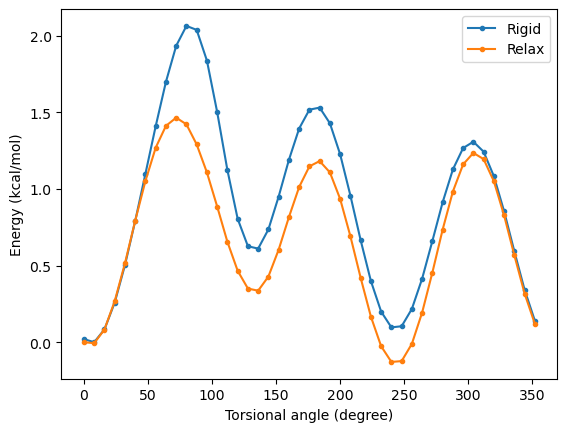

In [5]:
fig, ax = plt.subplots(1, 1)
plot_curve(x=angles1, y=rigid_E,
           relative_x=0, periodic_x=360, relative_y='min',
           ax=ax,
           xlabel='Torsional angle (degree)',
           ylabel='Energy (kcal/mol)')
plot_curve(x=angles2, y=relax_E,
           relative_x=0, periodic_x=360, relative_y=0,
           ax=ax,
           xlabel='Torsional angle (degree)',
           ylabel='Energy (kcal/mol)')
ax.legend(['Rigid', 'Relax'])


In [13]:
viewer = grid_viewer(viewer_grid=(1, 2), viewer_size=(800, 400), linked=True)

animation_viewer("".join(xyzs1), 'xyz', interval=120, viewer=viewer, viewer_loc=(0, 0))
animation_viewer("".join(xyzs2), 'xyz', interval=120, viewer=viewer, viewer_loc=(0, 1))

viewer

3Dmol.js failed to load for some reason. Please check your browser console for error messages.